<h1><center> The Bootstrap </center></h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### Example
 
*The following story is fictional and does not depict any actual person or event.*

Let's say that drug A has passed all testing and has been out long enough for companies to start getting generic drugs to come out. Although the generic drug company knows the active ingredients, it doesn't know how to "package" or produce that ingredient. After they feel they have figured it out, they need to demonstrate to regulators that their generic is "bioequivalent" to the brand name. Here, bioequivalent is about primarily about bioavailibility, not efficacy. 

This is usually accomplished using confidence intervals (CI).

### POP QUIZ
Give two-sided 95% confidence intervals for the :
* Height of male US citizens between ages of 30-40 in 2008 (in feet)
* Height of female US citizens between ages of 30-40 in 2008 (in feet)

Answers:

* ~ 5'3"-6'3" 
* ~ 4'11" - 5'10" 

In some cases, this is done by showing that the CIs for some biologically relevant features (usually about concentrations in various parts of the body) for the generic are within a small "neighborhood" ($\pm 20$%) of the CIs for the branded drug. 

Note that we are "testing a hypothesis", although it's not immediately clearly that this is a "hypothesis test".

![title](Bio_equivalent_figure.jpg)

For biological/probabilistic reasons, scientists can choose features which are log-normally distributed. This follows from a multiplicative form of the CLT, "Gilbrat's Law" reflecting the fact that these variables arise from a large number of  accumulations of small percent changes. 

In this case, we can choose our test statistic amenable to parametric methods, i.e. we have an approximate formula.

But what if we were coerced to examine a test statistic that didn't have such a nice analytic description?

This talk will go through how to do this without "making assumptions" about the form of distributions of the hypothesis (i.e. which parametric family it falls in). Instead of referencing tables, we will directly use our data.

In some some sense we are making "no assumptions", *other than that our data is sufficiently representative of what we are studying*

Here's the 

### Basic Idea:

* Get sample data
* Simulate randomness of the sampling process by creating "bootstrap" samples of the data
* Compute the value of the test statistic on each bootstrap sample
* Compute confidence interval of these values

### The Empirical Distribution

The basis of most nonparametric methods is to work (almost) exclusively with the quantities derived from the "empirical distribution". This is the "probability distribution generated by the data." 

----
Given independent data $X = (x_1, \ldots, x_n)$ and a probability distribution $\rho$, recall the likelihood of $X$ were $\rho$ true to be:

$$
\mathcal{L}_X (\rho) = \rho (X) = \prod_{i = 0}^n \rho(x_i)
$$
This quantifies the consistency of the data and the model.

The empirical distribution is the model that is "most consistent" with the data

$$
\rho_{X} = \arg\max_{\rho} \mathcal{L}_X (\rho) 
$$

Here, we are minimizing the likelihood of the data *subject to no conditions*, making this a "nonparametric" model.

_____
$\rho_X$ "really overfits", stating that unseen events are impossible, and the probability of an event is the number of occurences of the event in a sample divided by the size of the sample. 

_____
As an aside, note the expectation value (with respect to the empirical distribution) of any observable $\mathcal{O}$ is just it's sample average. 

$$
\mathbb{E}_{\rho_{X}} \bigl[\mathcal{O} \bigl] = \frac{1}{n}\sum_{i = 0}^n \mathcal{O}(x_i)
$$


Hence we can compute expected outcomes by plugging in the data. 

----

Throughout, we'll use very simple synthetic data, one generated from a unit gaussian, one generated from a standard exponential distribution

In [2]:
sample_size = 30
# normal distribution
normal_data = np.random.normal(0, 1, sample_size)
# skewed data, exponential distribution
exp_data = np.random.exponential(1, sample_size)

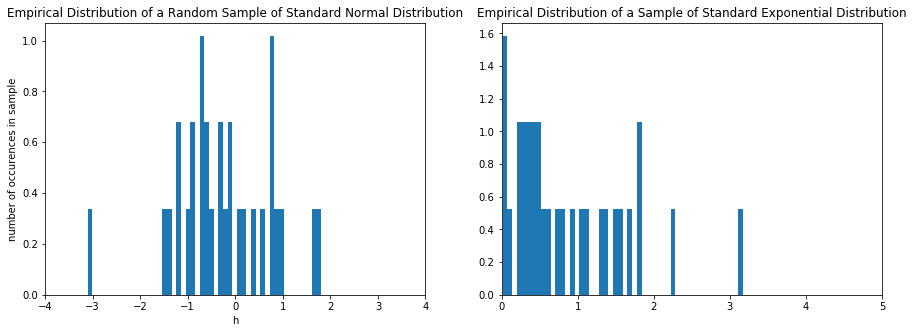

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins = 50
ax[0].hist(normal_data, bins=bins, density=True)
ax[0].set(
    xlim=(-4, 4),
    xlabel="h",
    ylabel="number of occurences in sample",
    title="Empirical Distribution of a Random Sample of Standard Normal Distribution",
)
ax[1].hist(exp_data, bins=bins, density=True)
ax[1].set(
    xlim=(0, 5),
    title="Empirical Distribution of a Sample of Standard Exponential Distribution",
);

## Bootstrap Samples

The bootstrap numerically approximates the uncertainty in a test statistic due to the sampling process.

A **bootstrap sample of $X$** is a sample (with the same size as $X$) drawn with replacement from $X$. 

* If $X$ was drawn from a probability distribution, $\rho$, a bootstrap sample models $N$ i.i.d. random variables.

The following code makes this explicit.


In [4]:
def btstrp_samples(N_btstrp, data):
    """
    Creates a bunch of bootstrap samples from the data
    
    Input:
    ------
    data = sample data 
    
    N_btstrp = number of bootstrap samples
    
    Output:
    -------
    btstrp_samples = 2 dimensional numpy array. 
                     First axis indexes which bootstrap sample. 
                     Second axis is the bootstrap sample.
    """
    sample_size = data.shape[0]
    # drawing with replacement = uniformly randomly generating indices
    indices = np.random.randint(0, sample_size, size=(N_btstrp, sample_size))
    btstrp_samples = data[indices]
    return btstrp_samples

Let's generate $10^3$ bootstrap samples from each:

In [5]:
N_btstrp = 10 ** 4
normal_btstrp = btstrp_samples(N_btstrp, normal_data)
exp_btstrp = btstrp_samples(N_btstrp, exp_data)

print("Example data:\n", normal_data[0:5])
print("5 bootstrap samples of the above:\n", btstrp_samples(6, normal_data[0:5]))

Example data:
 [ 1.80731217 -3.10404138 -0.32807689 -0.25174053 -0.69932765]
5 bootstrap samples of the above:
 [[-0.69932765 -0.32807689 -0.69932765 -3.10404138  1.80731217]
 [-0.25174053  1.80731217 -0.32807689 -3.10404138 -0.69932765]
 [-0.69932765 -0.69932765 -0.25174053 -0.69932765 -0.32807689]
 [-0.25174053  1.80731217 -0.69932765  1.80731217 -0.25174053]
 [-0.69932765 -0.25174053 -0.69932765 -0.25174053 -3.10404138]
 [-3.10404138 -0.32807689 -0.32807689 -0.69932765  1.80731217]]


## Test Statistics

Recall that a test statistics inputs a sample of size $n$, $X = (x_1, \ldots x_n)$ and outputs a number $T(X)$. 

For concreteness, we'll only consider the mean and the median. 

In [6]:
# mean
normal_mean = normal_data.mean()
exp_mean = exp_data.mean()

# median
normal_median = np.median(normal_data)
exp_median = np.median(exp_data)

print("Normal sample mean:\n", normal_mean)
print("Exponential sample mean:\n", exp_mean)
print("Normal sample median:\n", normal_median)
print("Exponential sample median:\n", exp_median)

Normal sample mean:
 -0.2315122547402513
Exponential sample mean:
 0.8636004200371779
Normal sample median:
 -0.31037910662722035
Exponential sample median:
 0.5896672763389601


The mean of the standard exponential distribution is 1, while the median $\simeq .7$.

Note that it's really hard to say anything analytic about median, despite how useful it is for understanding data with outliers. 

I would argue that this is really where the bootstrap shines: test statistics that are difficult to manipulate algebraically. 

## Distributions of Outcomes

We now compute the test statistic on each of the bootstrap samples. This generates a distribution of outcomes, which we can manipulate with the same tools as any other probability distribution.

In [7]:
# Compute the means of each bootstrap sample
normal_btstrp_means = normal_btstrp.mean(axis=1)
exp_btstrp_means = exp_btstrp.mean(axis=1)

# Compute the medians of each bootstrap sample
normal_btstrp_medians = np.median(normal_btstrp, axis=1)
exp_btstrp_medians = np.median(exp_btstrp, axis=1)

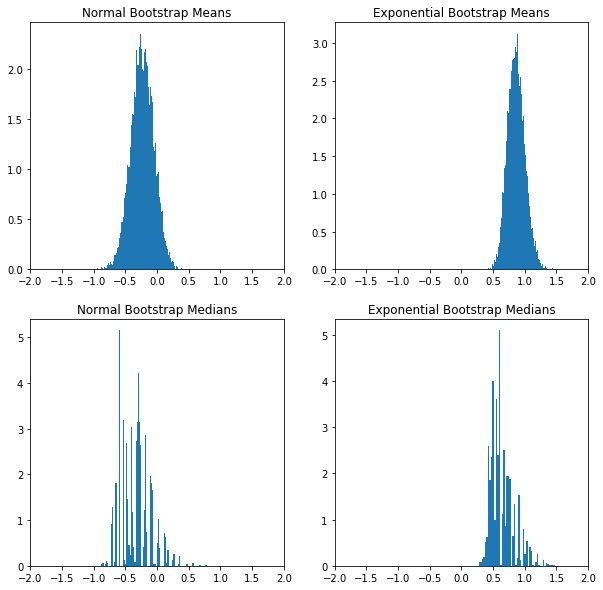

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].hist(normal_btstrp_means, density=True, bins=100)
ax[0, 0].set(xlim=(-2, 2), title="Normal Bootstrap Means")
ax[0, 1].hist(exp_btstrp_means, density=True, bins=100)
ax[0, 1].set(xlim=(-2, 2), title="Exponential Bootstrap Means")
ax[1, 0].hist(normal_btstrp_medians, density=True, bins=100)
ax[1, 0].set(xlim=(-2, 2), title="Normal Bootstrap Medians")
ax[1, 1].hist(exp_btstrp_medians, density=True, bins=50)
ax[1, 1].set(xlim=(-2, 2), title="Exponential Bootstrap Medians");

Note that the Central Limit theorem suggests the top right distribution should be normal. In particular, it should have zero skew. This is not always the case. 

As the exponential distrubution is skew, the sample size needs to be especially large for normal-distribution based (z, t) confidence intervals to be valid. This is one reason why bootstrap is "better for small samples"tg

In [9]:
stats.skew(exp_btstrp_means)

0.2384778842666818

In [12]:
print(
    "The mode of the bootstrap simulation of the mediand is:\n",
    stats.mode(np.round(exp_btstrp_medians, decimals=2))[0]
)
print("The 'true' median is:\n", np.log(2))

The mode of the bootstrap simulation of the mediand is:
 [0.59]
The 'true' median is:
 0.6931471805599453


Note that the normality of the distributions in the top row are a consequence of the CLT applied to the empirical distribution.  

In [11]:
print(exp_btstrp_means.std() * np.sqrt(30))
print(exp_btstrp_means.mean())

0.7481288363957243
0.864384638337859


## Confidence Intervals

Recall that given a probability distribution on $\mathbb{R}$, the (two sided) $100(1-\alpha)$% confidence interval is a range of values:

$$
[a_\alpha, b_\alpha]
$$
where one 
$$
\mathrm{P}(x \leq a_\alpha) = \frac{\alpha}{2} \\
\mathrm{P}(x \geq b_\alpha) = \frac{\alpha}{2}
$$

i.e. it's a range of values that covers $100(1-\alpha)$% of the "population".


## The Quantile and Basic Bootstrap CI 

There are a plethora of CIs we can generate from this bootstrapped distribution. Here are the three most basic ones:

1. "Quantile/Percentile CI": literally the CI of the distribution of the test statistic.
    * This makes no reference to the value of the test statistic on the original data.
    * Accuracy is "first-order" (scales with $n^{-\frac{1}{2}}$)
1. "Basic Bootstrap CI": This is a CI generated by looking at the deviations from the test statistic evaluated on the original data. 
    * Accuracy is "first-order" (scales with $n^{-\frac{1}{2}}$)
    * Corrects for bias
    * Better theoretical justification than the percentile CI
1. "Bias-Corrected and Accelerated ($\mathrm{BC}_a$) ": this is more involved to explain, but is in various senses "better" than the above two
    * Accuracy is "second-order" (scales with $n^{-1}$), making it more accurate than the basic 
    * Corrects for bias and skew in data
    * Is invariant of our chose parameterziation (e.g. our chosen units)

In general, one should go with the $\mathrm{BC}_a$ confidence intervals. *Many thanks to ChuChu Cheng for bringing this to my attention*

Below is how one would code the first two by hand:

In [163]:
def quantile_CI(X_btstrp, alpha):
    """
    Finds a confidence interval level with significance alpha 
    """
    a = np.quantile(X_btstrp, alpha / 2)
    b = np.quantile(X_btstrp, 1 - alpha / 2)
    return np.array([a, b])

def bsc_btstrp_CI(X_btstrp, alpha, estimate):
    # compute deviations from the original estimate
    deltaX = estimate - X_btstrp
    # add them to the original estimate
    X_deltaX = estimate + deltaX # 2 * estimate - X_btstrp
    # compute the ordinary CI for this new distribution
    btstrp_CI = quantile_CI(X_deltaX, alpha)
    return btstrp_CI

In [158]:
print("The 95% quantile CI for the exponential distrubition is:\n", quantile_CI(normal_btstrp_means, 0.05))
print("The 95% basis bootstrap CI for the exponential distrubition is:\n", bsc_btstrp_CI(normal_btstrp_means, 0.05, normal_mean))
print("While the z-test say it is: \n", 
      [normal_mean - normal_data.std() * 1.96 /np.sqrt(normal_data.shape[0]),
    normal_mean + normal_data.std() * 1.96 /np.sqrt(normal_data.shape[0])])

The 95% quantile CI for the exponential distrubition is:
 [-0.42271372  0.24848376]
The 95% basis bootstrap CI for the exponential distrubition is:
 [-0.42399016  0.24720733]
While the z-test say it is: 
 [-0.4247023051310682, 0.24919591012350764]


Math tells us that (for large $n$) the probability that the test statistic lies in the $100(1- \alpha)$% basic bootstrap interval is indeed $1-\alpha$

# Bootstrap Intervals with Arch

Fortunately, there's a really nice Python package (Arch) which computes these plethora of bootstrap intervals for you.
We can do this with the `IIDBootstrap` object. 

Documentation may be found at:

https://arch.readthedocs.io/en/latest/bootstrap/confidence-intervals.html



In [18]:
from arch.bootstrap import IIDBootstrap

In [42]:
bs = IIDBootstrap(exp_data)

In [28]:
test_statistic = np.mean
N = 10 ** 3
pci = bs.conf_int(test_statistic, reps=N, method="percentile")
bci = bs.conf_int(test_statistic, reps=N, method="basic")
bcaci = bs.conf_int(test_statistic, reps=N, method="bca")

array([[-0.61218566],
       [ 0.11261196]])

In [41]:
print("Percentile/Quantile CI:\n", np.round(pci[:, 0], decimals=2))
print("Basic CI:\n", np.round(bci[:, 0], decimals=2))
print("Bias-Corrected and Accelerated:\n", np.round(bci[:, 0], decimals=2))

Percentile/Quantile CI:
 [-0.61  0.11]
Basic CI:
 [-0.57  0.13]
Bias-Corrected and Accelerated:
 [-0.57  0.13]


### Bootstrap A/B Testing

Scheme I: 

* Choose a test statistic and a null hypothesis
* Compute the test statistic for the null
* Use data to compute the basic bootstrap confidence interval 
* If the null's test statistic is outside of this CI, reject the null.
    * Alternatively, you can compare the CI generated by the null "parametric bootstrap"

Questions: 

* What's the acceptance region of this test?
* What's the significance level of this test? 
* What's the power of this test?
* How would you compute these ahead of time?

## Conclusion:

* The bootstrap simulates the randomness coming from the sampling process.
* Is especially useful for test statistics that don't admit an analytic description
* Also can be used when the distribution goes towards a nice form too slowly
    * "small sample"
* It's not a cure-all for small sample sizes
* Can also be used to "protect against model misspecification" when parametric methods (MLEs) are used.
